<a href="https://colab.research.google.com/github/Mitmischer/solar-prediction/blob/main/notebook_3_univariate_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install armagarch pyextremes

In [3]:
!pip install gluonts armagarch statsmodels statsforecast s3fs datasetsforecast GPy

In [4]:
!pip install git+https://github.com/Nixtla/neuralforecast.git@main git+https://github.com/RJT1990/pyflux

  Cloning https://github.com/Nixtla/neuralforecast.git (to revision main) to /tmp/pip-req-build-pq1zvboi
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /tmp/pip-req-build-pq1zvboi
  Resolved https://github.com/Nixtla/neuralforecast.git to commit 2035ef64f9ab6e3d69d720fb13aed9d42544546e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-6egt7ob4
  Running command git clone --filter=blob:none --quiet https://github.com/RJT1990/pyflux /tmp/pip-req-build-6egt7ob4
  Resolved https://github.com/RJT1990/pyflux to commit 297f2afc2095acd97c12e827dd500e8ea5da0c0f
  Preparing metadata (setup.py) ... done


In [5]:
!pip install darts

# Notebook parameters

In [6]:
# if False, cells that take a lot of time are not run.
# For production and the actual results, use slow=True!
slow = False

# Data Preparation

In [7]:
import huggingface_hub
import pandas as pd
import numpy as np

In [8]:
splits = {'train': 'train_ts.csv', 'validation': 'val_ts.csv', 'test': 'test_ts.csv'}
df_train = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["train"])
df_validation = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["validation"])
df_test = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
df = pd.concat([df_train, df_validation, df_test])
ts = df["Leistung"]
ts.index = pd.to_datetime(ts.index, utc=True)

In [10]:
ts

2014-12-31 23:00:00+00:00        0.0
2015-01-01 00:00:00+00:00        0.0
2015-01-01 01:00:00+00:00        0.0
2015-01-01 02:00:00+00:00        0.0
2015-01-01 03:00:00+00:00        0.0
                              ...   
2024-05-01 17:00:00+00:00    14386.7
2024-05-01 18:00:00+00:00     1648.6
2024-05-01 19:00:00+00:00        1.5
2024-05-01 20:00:00+00:00        0.0
2024-05-01 21:00:00+00:00        0.0
Name: Leistung, Length: 81815, dtype: float64

<Axes: >

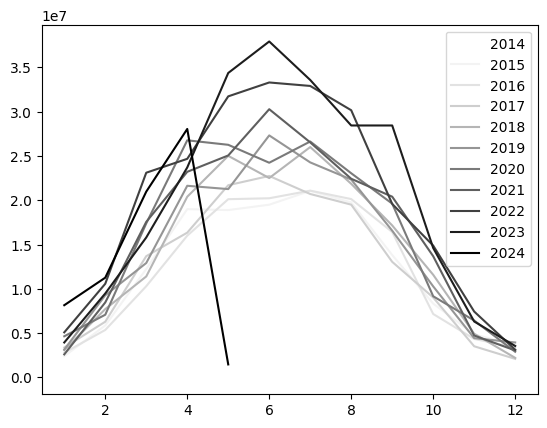

In [11]:
# see https://stackoverflow.com/questions/30379789/plot-pandas-data-frame-with-year-over-year-data
pv = pd.pivot_table(df, index=ts.index.month, columns=ts.index.year,
                    values='Leistung', aggfunc='sum')
pv.plot(cmap="Greys")

The increasing monthly trend is clearly visible.

In [12]:
# Those values need imputation!
pd.date_range(ts.index.min(), ts.index.max(), freq='15Min').difference(ts.index)

DatetimeIndex(['2014-12-31 23:15:00+00:00', '2014-12-31 23:30:00+00:00',
               '2014-12-31 23:45:00+00:00', '2015-01-01 00:15:00+00:00',
               '2015-01-01 00:30:00+00:00', '2015-01-01 00:45:00+00:00',
               '2015-01-01 01:15:00+00:00', '2015-01-01 01:30:00+00:00',
               '2015-01-01 01:45:00+00:00', '2015-01-01 02:15:00+00:00',
               ...
               '2024-05-01 17:45:00+00:00', '2024-05-01 18:15:00+00:00',
               '2024-05-01 18:30:00+00:00', '2024-05-01 18:45:00+00:00',
               '2024-05-01 19:15:00+00:00', '2024-05-01 19:30:00+00:00',
               '2024-05-01 19:45:00+00:00', '2024-05-01 20:15:00+00:00',
               '2024-05-01 20:30:00+00:00', '2024-05-01 20:45:00+00:00'],
              dtype='datetime64[ns, UTC]', length=245442, freq=None)

In [13]:
# Interpolation
ts = ts.interpolate(method="time")
# Only now can we infer a frequency.
ts = ts.asfreq(pd.infer_freq(ts.index))

In [14]:
# Normalize
avg_train, dev_train = ts.mean(), ts.std()
ts_series = (ts - avg_train)/dev_train

<Axes: >

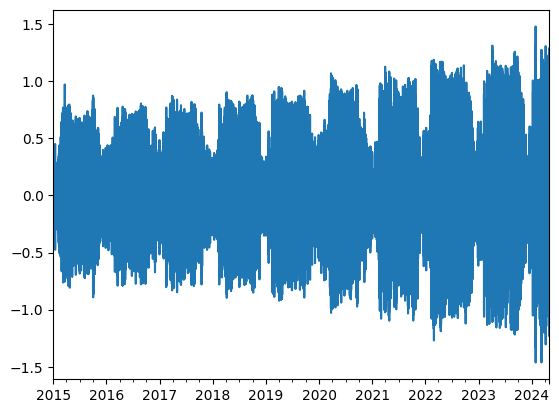

In [15]:
# Remove trend
ts_series = ts_series.diff().dropna()
ts_series.plot()

In [16]:
# remove increasing volatility

def remove_volatility(ts):
    annual_volatility = ts.groupby(ts.index.year).std()
    annual_vol_per_day = ts.index.map(lambda d: annual_volatility.loc[d.year])
    ts_corrected_variance = ts/annual_vol_per_day
    monthly_mean = ts_corrected_variance.groupby(ts_corrected_variance.index.month).mean()
    monthly_mean_per_day = ts_corrected_variance.index.map(lambda d: monthly_mean.loc[d.month])
    ts_corrected_variance= ts_corrected_variance - monthly_mean_per_day
    ts_corrected_variance= ts_corrected_variance[~np.isnan(ts_corrected_variance)]
    return ts_corrected_variance

In [17]:
annual_volatility = ts.groupby(ts.index.year).std()
annual_vol_per_day = ts.index.map(lambda d: annual_volatility.loc[d.year])

<Axes: >

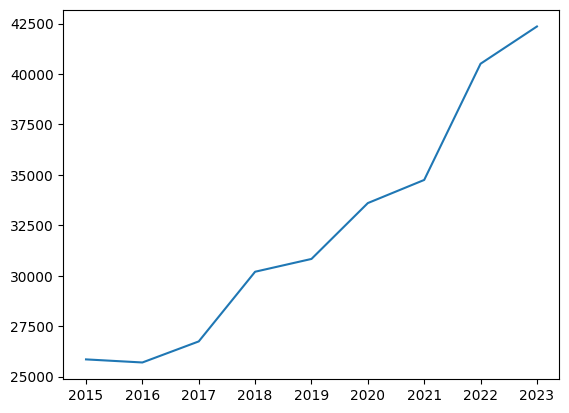

In [18]:
annual_volatility[0:10].plot()

Removing the increasing volatility will yield a perfectly stationary time series. One might argue that this is information leakage, but the annual volatility follows a linear trend and is inferrable.
The values for 2024 are removed from the plot as the year 2024 is not complete (and has a lower volatility).

<Axes: >

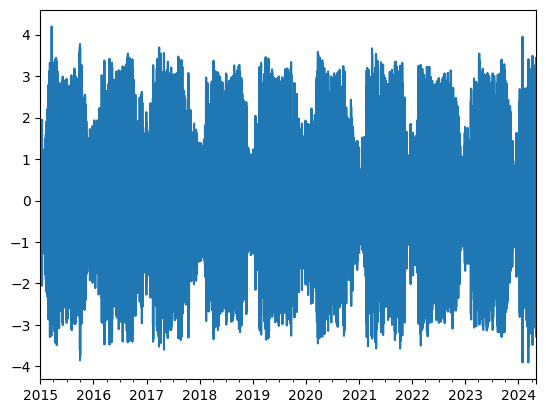

In [19]:
ts = remove_volatility(ts_series)
ts.plot()

# Spectral Analysis

In [38]:
# spectral analysis
from scipy import signal
from scipy.signal import periodogram as periodogram_f
from scipy.fft import fftfreq, fftshift
from scipy.fft import fft, ifft, fft2, ifft2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

(0.0, 5000.0)

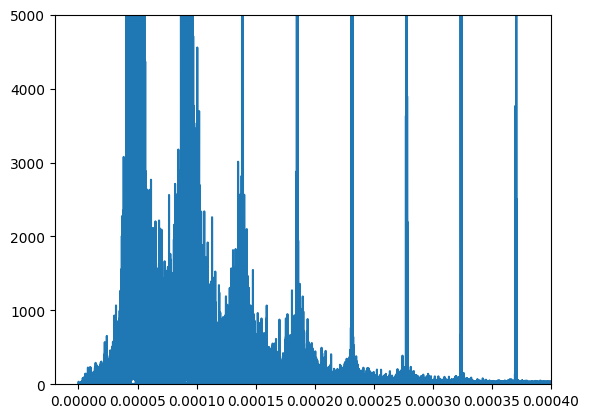

In [39]:
# looks (and should be!) similar to the "manual" calculation above.
# Note that in the manual calculation, we get a symmetric graph. That's to be expected (check out the videos).
dt = 15*60
rate = 1/dt
frequencies, periodogram = periodogram_f(np.asarray(ts), fs=rate, window="hamming")
plt.plot(fftshift(frequencies), fftshift(periodogram))
plt.xlim(-0.00002, 0.0001*4)
plt.ylim(0, 10000/2)

We see some clear peaks corresponding to strong frequencies in the signal.

(0.0, 25000.0)

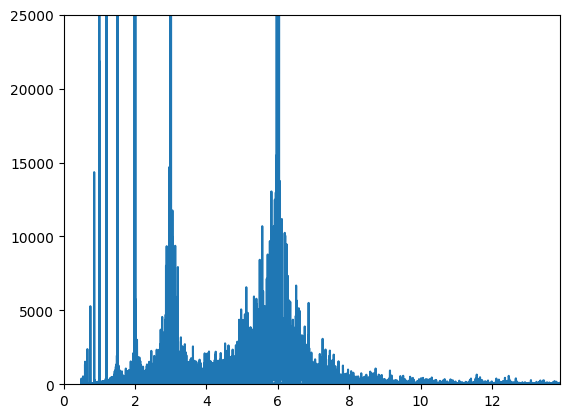

In [40]:
periodogram_as_series = pd.Series(fftshift(periodogram), index=fftshift(frequencies))
periodogram_as_series = periodogram_as_series[periodogram_as_series.index > 0]
# convert index from frequencies to periods and convert the periods to hours
# TODO: is the calculation to hours correct (note that  we already specified the sampling rate during the fft!)?
periodogram_as_series.index = (1/periodogram_as_series.index)/3600
plt.plot(periodogram_as_series)
plt.xlim(0,100000/3600/2)
plt.ylim(0, 5000*10/2)

The frequencies can be converted to time intervals.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 1.6666666666666667)

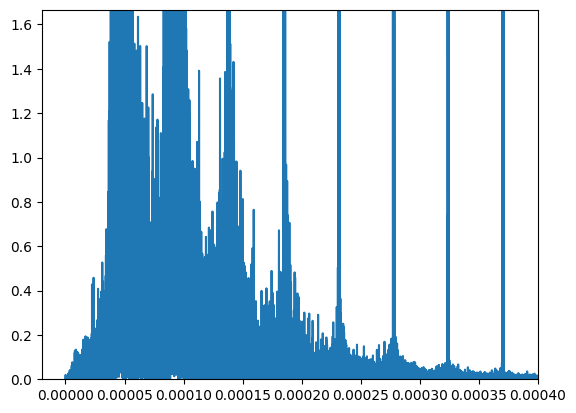

In [41]:
# yet another way to calculate the FFT, from the "denoising" video.
# That'll allow us to drop frequencies later.
n = len(ts)
fhat = np.fft.fft(ts, n)
PSD = fhat*np.conj(fhat)/n
freq = (1/(dt*n))*np.arange(n)
L= np.arange(1, np.floor(n/2), dtype="int")
plt.plot(freq[L], PSD[L])
plt.xlim(-0.00002, 0.0001*4)
plt.ylim(0, 10000/(1500*4))

[]

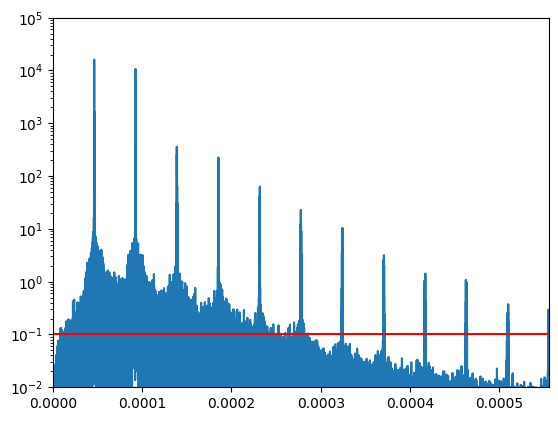

In [42]:
# Now decide on the frequencies to cut off.
plt.plot(freq, PSD)
plt.ylim(1e-2,1e5)
plt.xlim(0,max(freq)/2)
plt.axhline(y=1e-1, color="r")
plt.semilogy()

We want to keep the strong frequencies in the signal and remove the other ones (which make the signal noisy).
Visually, a cutoff of 1 drops a lot of less important frequencies while keeping ~80% of the major ones.

In [43]:
indices = PSD > 1e-1
# Filter and reconstruct the signal on the retained frequencies (reverse fourier transform)
PSDclean = PSD*indices
fhat = indices*fhat
ffilt = np.fft.ifft(fhat)

In [44]:
# number of surviving frequencies
np.sum(indices)

15865

[]

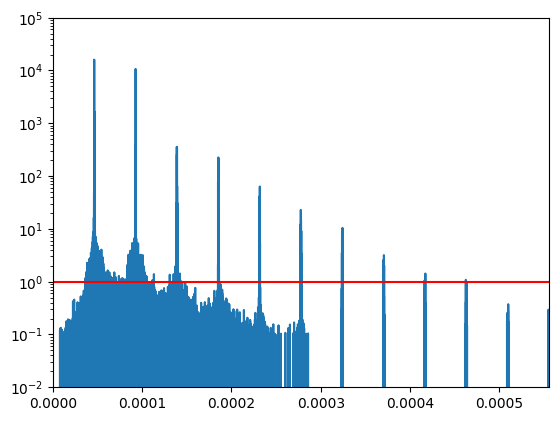

In [45]:
plt.plot(freq, PSDclean)
plt.ylim(1e-2,1e5)
plt.xlim(0,max(freq)/2)
plt.axhline(y=1e0, color="r")
plt.semilogy()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


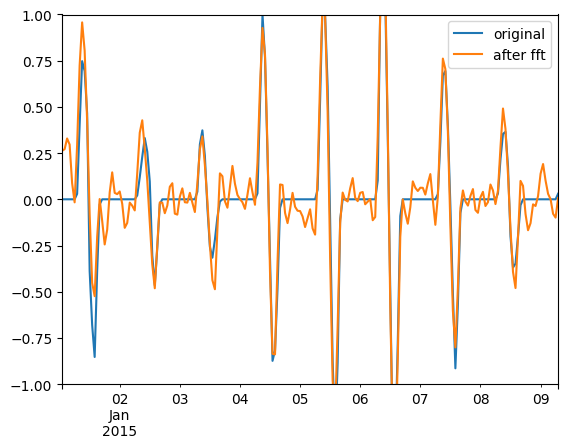

In [46]:
ts[1:200].plot()
plt.ylim(-4,4)
pd.Series(ffilt[1:200], ts.index[1:200]).plot()
plt.ylim(-1,1)
plt.legend(["original", "after fft"])

Generally, in many of the settings we investigated, FFT had problems with the zero production at night.
You can play around with the parameter in
`indices = PSD > X`
to obtain the comparisons in the presentation.
The FT model later in the notebook will work better, maybe by a better choice of parameters?

# Gaussian Processes

We employ Gaussian processes as a filtering / preprocessing method, not for forecasting.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from darts import TimeSeries
from darts.models import GaussianProcessFilter
from darts.utils import timeseries_generation as tg

<Axes: xlabel='Datum'>

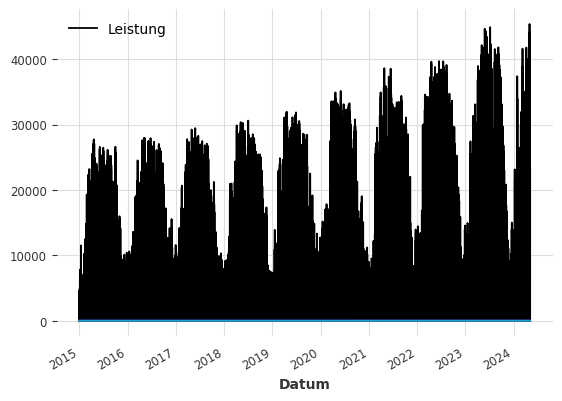

In [97]:
# The Gaussian Process will *not* work on the hourly data, but only
# on the 15-minute data (!). Therefore, we need to have this in the meantime.
solar_ts=pd.read_csv("/content/drive/MyDrive/energy_charts.csv", sep=",", header=0)#date_format='%Y-%m-%d %H:%M:%S%z')#parse_dates={"date": ["Datum"]})
solar_ts['Datum']=pd.to_datetime(solar_ts['Datum'], format='%Y-%m-%dT%H:%M%z', utc=True)
solar_ts=solar_ts.set_index(keys="Datum",drop=True)
solar_ts.plot()
# This add NaN as value for the missing indices, we can impute this later.
solar_ts = solar_ts.resample("15Min").first()
# As only a few values need imputation, so the choice of the imputation algorithm does not matter much.
solar_ts = solar_ts.interpolate(method="time")
# Only now can we infer a frequency.
solar_ts=solar_ts.asfreq(pd.infer_freq(solar_ts.index))
solar_ts_series = solar_ts.Leistung
# Normalize
train_size = int(len(solar_ts_series) * 0.9)
ts_train = solar_ts_series[:train_size]
ts_test = solar_ts_series[train_size:]

# we cannot normalize over the test data as we don't have that yet!
avg, dev = ts_train.mean(), ts_train.std()
solar_ts_series = (solar_ts_series - avg)/dev
solar_ts_series.plot()
# Remove trend (TODO: compare with the approach in the Fourier series video, where they also detrend?)
solar_ts_series = solar_ts_series.diff().dropna()
solar_ts_series.plot()
# remove increasing volatility - or (TODO: use a (G)ARCH here).
annual_volatility = solar_ts_series.groupby(solar_ts_series.index.year).std()
annual_vol_per_day = solar_ts_series.index.map(lambda d: annual_volatility.loc[d.year])
solar_ts_series_corrected_variance = solar_ts_series/annual_vol_per_day
solar_ts_series_corrected_variance.plot()

In [98]:
from darts import TimeSeries

train_size = np.sum(solar_ts_series_corrected_variance.index < pd.Timestamp('2020-01-01 00:00:00+0000', tz='UTC'))

ts_train = solar_ts_series_corrected_variance[:train_size]
ts_test = solar_ts_series_corrected_variance[train_size:]

darts_ts_train = TimeSeries.from_series(ts_train)
darts_ts_test = TimeSeries.from_series(ts_test)

In [99]:
NOISE_DISTANCE = 0.4
SAMPLE_SIZE = 200
np.random.seed(42)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


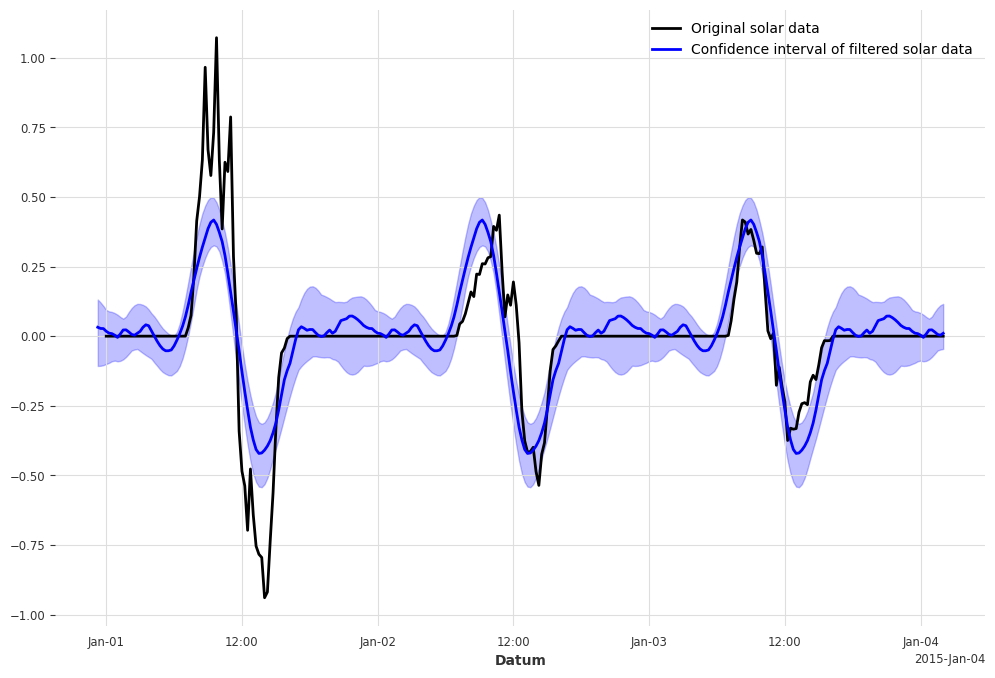

In [103]:
kernel = ExpSineSquared()

gpf = GaussianProcessFilter(
    kernel=kernel, alpha=NOISE_DISTANCE / 2, n_restarts_optimizer=100
)


filtered_x_samples = gpf.filter(darts_ts_train[:300], num_samples=10)

plt.figure(figsize=[12, 8])
darts_ts_train[:300].plot(color="black", label="Original solar data")
filtered_x_samples.plot(color="blue", label="Confidence interval of filtered solar data")
plt.legend()

Given the general energy curve shape (sinusoidal) and the increasing trend in data volatility, ExpSineSquared is the obvious first choice, but its performance is not great.
The results look similar to FFT (will be presented later in this notebook), but there is big problem - the resulting output is just repetitive (each 1-day period is identical).
We've seen this for the FFT, too, if too few frequencies were retained. Even for the very small training set, the cell takes a lot of time to execute, so the effect of raising num_samples could not be investigated further. Also, the runtimes are unbearingly slow.


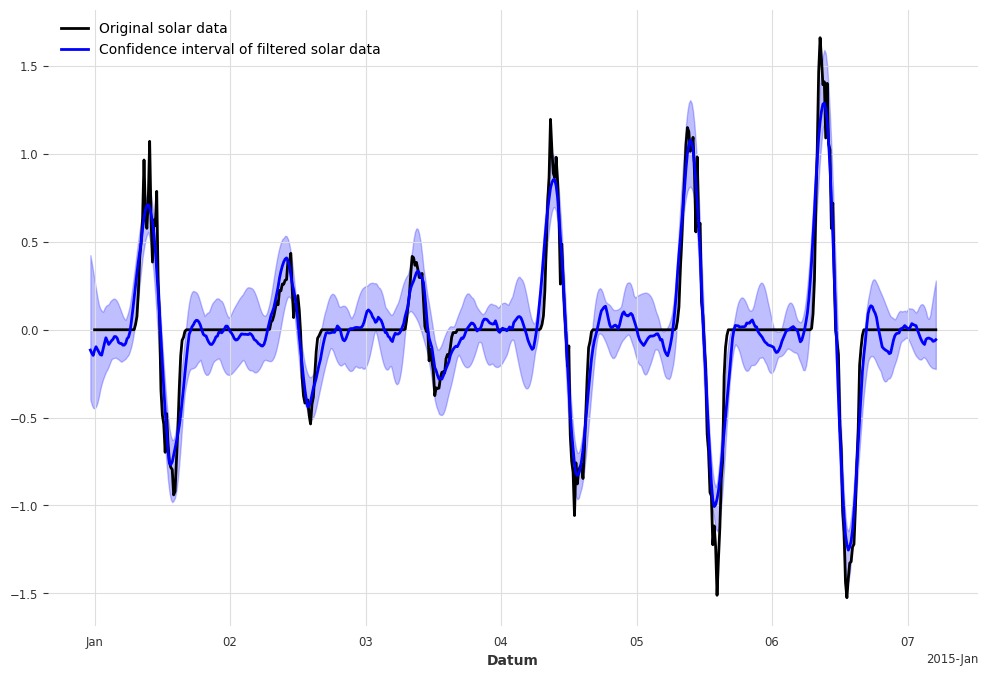

In [104]:
kernel = RBF()

gpf = GaussianProcessFilter(
    kernel=kernel, alpha=NOISE_DISTANCE / 2, n_restarts_optimizer=100
)

filtered_x_samples = gpf.filter(darts_ts_train[:600], num_samples=10) # num_samples were 100

plt.figure(figsize=[12, 8])
darts_ts_train[:600].plot(color="black", label="Original solar data")
filtered_x_samples.plot(color="blue", label="Confidence interval of filtered solar data")
plt.legend()

The RBF kernel performs much better here, capturing the general peak height. Still, as with FFT, there are problems at night time.
One can safely reduce num_samples to 50 without high increases in error, still the high execution times make applying the filter on the whole dataset unfeasible.

# Anomaly Detection



In [52]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [53]:
TIME_STEPS = 288

# Generated training sequences for use in the model:
# rolling windows of size TIME_STEPS
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def prepare_data(x, sample_type, time_steps):
    # normalize x (=train or test data) and create windows.
    x_mean = x.mean()
    x_std = x.std()
    df_training_value = (x - x_mean) / x_std
    print(f"Number of {sample_type} samples:", len(x))

    x_ret = create_sequences(df_training_value.values, time_steps)
    print("{sample_type} input shape: ", x_ret.shape)
    return x_ret

def AE_anomaly_detection(simple, x_train, x_test, time_steps):
    x_train = prepare_data(x_train, "training", time_steps)

    if simple:
      model = keras.Sequential(
          [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
          ]
      )
    else:
      model = keras.Sequential(
          [
            layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])),
            layers.Dropout(rate=0.2),
            layers.RepeatVector(x_train.shape[1]),
            layers.LSTM(128, return_sequences=True),
            layers.Dropout(rate=0.2),
            layers.TimeDistributed(layers.Dense(x_train.shape[2])),
          ]
      )


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
       ],
    )

    ## Get train MAE loss, compute reconstruction error threshold.
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    # Here, we use 90% of the maximum training threshold, but one could
    # experiment with this value!
    threshold = np.max(train_mae_loss)*0.9
    print("Reconstruction error threshold: ", threshold)


    x_test = prepare_data(x_test, "test", time_steps)

    ## Get test MAE loss, determine anomalous slices.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the anomalous slices.
    anomalies = test_mae_loss > threshold
    print(anomalies)
    print("Number of anomaly samples: ", np.sum(anomalies))
    return anomalies

Number of training samples: 3000
{sample_type} input shape:  (2929, 72, 1)
Epoch 1/50
21/21 [==============================] - 2s 41ms/step - loss: 0.7607 - val_loss: 0.1759
Epoch 2/50
21/21 [==============================] - 1s 25ms/step - loss: 0.1986 - val_loss: 0.0809
Epoch 3/50
21/21 [==============================] - 1s 24ms/step - loss: 0.1270 - val_loss: 0.0621
Epoch 4/50
21/21 [==============================] - 0s 22ms/step - loss: 0.1047 - val_loss: 0.0516
Epoch 5/50
21/21 [==============================] - 1s 26ms/step - loss: 0.0913 - val_loss: 0.0447
Epoch 6/50
21/21 [==============================] - 0s 23ms/step - loss: 0.0811 - val_loss: 0.0395
Epoch 7/50
21/21 [==============================] - 1s 24ms/step - loss: 0.0735 - val_loss: 0.0346
Epoch 8/50
21/21 [==============================] - 1s 25ms/step - loss: 0.0669 - val_loss: 0.0305
Epoch 9/50
21/21 [==============================] - 1s 27ms/step - loss: 0.0606 - val_loss: 0.0270
Epoch 10/50
21/21 [===============

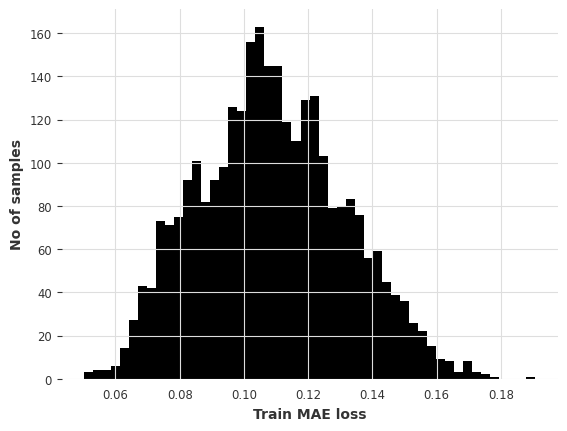

Reconstruction error threshold:  0.17156481229522275
Number of test samples: 76813
{sample_type} input shape:  (76742, 72, 1)
2399/2399 [==============================] - 12s 5ms/step


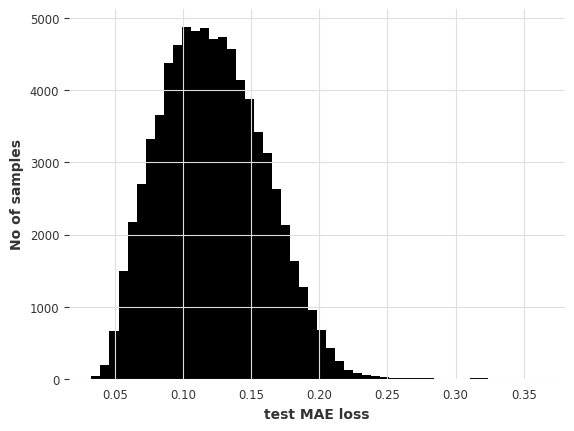

[False False False ...  True  True  True]
Number of anomaly samples:  7742


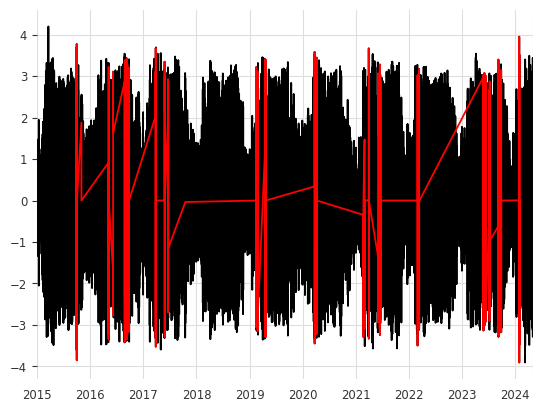

In [54]:
TIME_STEPS = 72 # window slice size
# this parameter determines the train-test split
# generally, also with just very little training data, anomaly detection looks
# reasonable.
train_end_idx=5000

test_part = ts[(train_end_idx+1):]

# Change simple to False to use an LSTM instead of a simple CNN.
anomalies = AE_anomaly_detection(True, ts.iloc[2000:train_end_idx].to_frame(),
                                 ts.iloc[(train_end_idx+1):].to_frame(),
                                 time_steps=TIME_STEPS)

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_part) - TIME_STEPS + 1):
    # get all windows where the sample is in.
    sample_anomalies = anomalies[data_idx - TIME_STEPS + 1 : data_idx]
    # a sample is anomalous if it is in more than 90% anomalous windows
    if np.mean(sample_anomalies) > 0.9:
        anomalous_data_indices.append(data_idx)
abnormal_subset = test_part.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
ts.plot(legend=False, ax=ax)
if len(abnormal_subset)>0:
  abnormal_subset.plot(legend=False, ax=ax, color="r")
plt.show()

The histograms show the reconstruction errors on the training and test samples, respectively. The cutoff is set to 90% of the maximum reconstruction error on the training samples.

Note that the first 2000 time points were skipped as this yields a more regular histogram (without a heavy right tail).
In the original series (with a frequency of 15 minutes), the histogram was regular without this preprocessing.

Play around with the parameter simple to select either the CNN or the LSTM and
the parameter train_end_idx.
Only samples in the test set are evaluated for being anomalous, but we could apply the test on the training data, too.
Note that for the plots in the presentation, the time series with increasing volatility was used.

# NBEATS (Darts), (works on the 1h data), *should* be good to go, needs testing on the GPU.

In [20]:
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts import concatenate

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [31]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

<Axes: xlabel='time'>

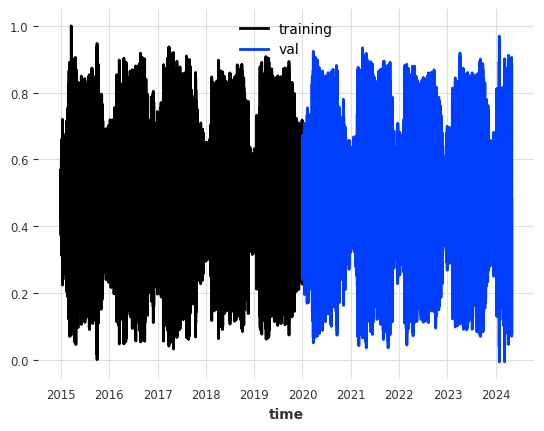

In [32]:
scaler = Scaler()

train_size = np.sum(ts.index < pd.Timestamp('2020-01-01 00:00:00+0000', tz='UTC'))
ts_train = ts[:train_size]
ts_test = ts[train_size:]

# data is not normal yet!
darts_ts_train = scaler.fit_transform(TimeSeries.from_series(ts_train))
darts_ts_test = scaler.transform(TimeSeries.from_series(ts_test))
darts_ts_full = scaler.transform(TimeSeries.from_series(ts))

darts_ts_train.plot(label="training")
darts_ts_test.plot(label="val")

In [33]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [34]:
# be sure to activate gpu if you have one (three cells above this one)
if slow:
  model_nbeats.n_epochs = 100
  model_nbeats.fit(darts_ts_train, val_series=darts_ts_test)
else:
  model_nbeats.n_epochs = 20
  model_nbeats.fit(darts_ts_train[0:500], val_series=darts_ts_test[0:500])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 8.1 M  | train
-------------------------------------------------------------
8.1 M     Trainable params
2.7 K     Non-trainable params
8.1 M     Total params
32.368    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [35]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


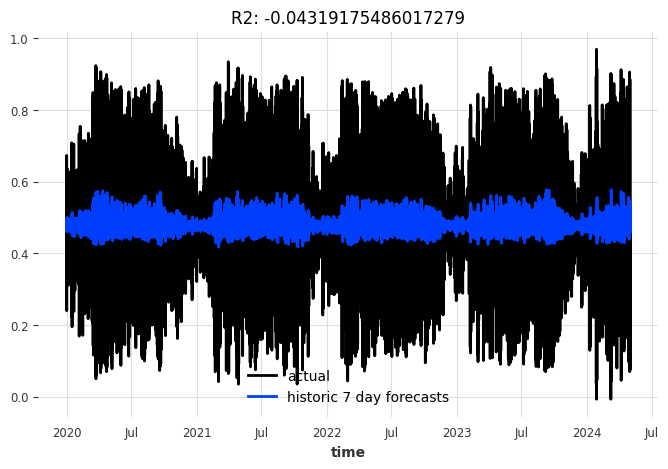

In [36]:
pred_series = model_nbeats.historical_forecasts(
    darts_ts_full,
    start=darts_ts_test.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

display_forecast(
    pred_series,
    darts_ts_full,
    "7 day",
    start_date=darts_ts_test.start_time(),
)

In [41]:
nbeats_pred = model_nbeats.predict(n=24*7)
nbeats_test = darts_ts_test[0:(24*7)]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


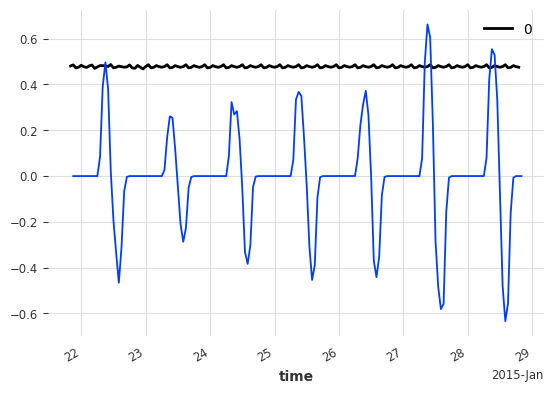

In [42]:
if slow:
  nbeats_pred.plot()
  nbeats_test.plot()
else:
  nbeats_pred.plot()
  ts_train[501:(501+24*7)].plot()

# NHITS

In [ ]:
from statsforecast import StatsForecast
from ray import tune

from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.core import NeuralForecast

from neuralforecast.losses.pytorch import DistributionLoss, MQLoss

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
ts_nhits = ts.reset_index().rename(columns={"index":"ds", 0:"y"})
# NeuralForecast is inherently multivariate. We just assign UID as our unique
# id, the exact choice doesn't matter.
ts_nhits.insert(column="unique_id", value="UID", loc=0)

In [ ]:
StatsForecast.plot(ts_nhits, engine='matplotlib')

Everything's set up!

In [ ]:
horizon = 24*5 # We run into GPU-RAM limitations for larger horizons


# in the tune.choice, one can also specify multiple choices and NeuralForecase
# will optimize. That would take too long for us, though.
nhits_config = {
    "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
    "max_steps": tune.choice([50]),                                         # Number of SGD steps
    "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horiz
    "batch_size": tune.choice([7]),                                           # Number of series in windows
    "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
    "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
    "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
    "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
    "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
    "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
    "random_seed": tune.randint(1, 10),
    "scaler_type": tune.choice(['robust']),
    "val_check_steps": tune.choice([100])
  }

In [ ]:
models = [AutoNHITS(h=horizon,
                    loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                    config=nhits_config,
                    num_samples=3)] # num_samples war 5

nf = NeuralForecast(
    models=models,
    freq="1h"
)

In [ ]:
if slow:
  nf.fit(df=ts_nhits[1:(len(ts_nhits)-5*24)])
else:
  # only test on a small subset to make sure the code is working etc.
  # NOT for production.
  nf.fit(df=ts_nhits[1:2000])

In [ ]:
fcst_df = nf.predict()
# in my understanding, the AutoNHITS column will have this information already,
# so we just drop this one (differing from the tutorial).
fcst_df = fcst_df.drop("AutoNHITS-median", axis=1)

In [ ]:
if slow:
  StatsForecast.plot(ts_nhits, fcst_df,engine='matplotlib', level=[80, 90])
else:
  StatsForecast.plot(ts_nhits[2000-24:(2000+5*24)], fcst_df,engine='matplotlib', level=[80, 90])

In [ ]:
# as an aside, NeuralForecast also supports LSTM, so one could also do a full model comparison as follows:

if False:
  config_lstm = {
      "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
      "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
      "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
      "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
      "scaler_type": tune.choice(['robust']),                   # Scaler type
      "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
      "batch_size": tune.choice([1, 4]),                        # Number of series in batch
      "random_seed": tune.randint(1, 20),                       # Random seed
  }

  models.append(AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2))
# .. then run NeuralForecast as above.

# Model Class, Backtesting, Metrics


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Plot Naive Model
naive_model = moving_average(ts)

test_date_start = '2024-01-01 00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Naive Model v.s. Original Data')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
class TimeSeriesPredictionModel():
    """
    Time series prediction model implementation

    Parameters
    ----------
        model_class : class
            Choice of regressor
        model_params : dict
            Definition of model specific tuning parameters

    Functions
    ----------
        init: Initialize model with given parameters
        train : Train chosen model
        forecast : Apply trained model to prediction period and generate forecast DataFrame
    """
    def __init__(self, model_class, model_params: dict) -> None:
        """Initialize a new instance of time_series_prediction_model."""
        self.model_class = model_class
        self.model_params = model_params
        self.model = None
        self.is_univariate = 'endog' in model_class.__init__.__code__.co_varnames

    def train(self, X_train: pd.DataFrame = None, y_train: pd.Series = None, train_series: pd.Series = None) -> None:
        """Train chosen model."""

        if self.is_univariate:
            if train_series is None:
                raise ValueError("train_series must be provided for univariate models")
            self.train_series = train_series
            self.model = self.model_class(endog=self.train_series, **self.model_params)
            self.model = self.model.fit()
        else:
            if X_train is None or y_train is None:
                raise ValueError("X_train and y_train must be provided for multivariate models")
            self.X_train = X_train
            self.y_train = y_train
            print("hello world")
            self.model = self.model_class(**self.model_params)
            self.model.fit(self.X_train, self.y_train)

    def forecast(self, X_test: pd.DataFrame = None, start_date: str = None, end_date: str = None) -> pd.DataFrame:
        """Apply trained model to prediction period and generate forecast DataFrame."""
        if self.is_univariate:
            #if steps is None:
            if start_date is None or end_date is None:
                raise ValueError("start_date and end_date must be provided for univariate models")
            #forecast = self.model.predict(start = start_date, end= end_date, typ = 'levels')
            # Make predictions
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)
            forecast = self.model.predict(start=start_date, end=end_date, typ='levels')

            # forecast = self.model.forecast(steps)
            forecast_df = pd.DataFrame(forecast, columns=['Forecast'])
        else:
            if X_test is None:
                raise ValueError("X_test must be provided for multivariate models")
            self.X_test = X_test
            forecast_df = pd.DataFrame(self.model.predict(self.X_test), index=self.X_test.index)
            forecast_df.index.name = 'Datum'
        return forecast_df

In [ ]:
# Backtesting with sliding window

def backtesting(X_train: pd.DataFrame, y_train: pd.DataFrame,
                X_test: pd.DataFrame, y_test: pd.DataFrame,
                model: TimeSeriesPredictionModel, prediction_step_size: int=96):
    """
    Perform rolling forecast backtesting for a time series prediction model using
    specified train and test datasets, and a given model.

    This function splits the test data into multiple windows based on the
    prediction_step_size and sequentially forecasts each window. After each
    forecasting step, the window of test data used for the current prediction is
    added to the training data, and the earliest window of the training data is
    removed. The predictions are stored in a DataFrame alongside the original test data values.

    Args:
        X_train (pd.DataFrame): Training feature dataset.
        y_train (pd.DataFrame): Training target dataset.
        X_test (pd.DataFrame): Testing feature dataset.
        y_test (pd.DataFrame): Testing target dataset.
        model (TimeSeriesPredictionModel): The model used for time series forecasting.
        prediction_step_size (int): The number of time steps to predict at each iteration.

    Returns:
        pd.DataFrame: A DataFrame with two columns 'Original' and 'Predictions',
                      containing the actual values from y_test and the predictions
                      made by the model, respectively.
    """

    # initializing output df
    predictions = pd.DataFrame(index=y_test.index, columns=['Original', 'Predictions'])
    predictions['Original'] = y_test

    for i in range(0, len(X_test)-prediction_step_size, prediction_step_size):
        end_idx = i + prediction_step_size
        forecast_index= X_test.iloc[i:end_idx].index

        # fit model and predict
        model.train(X_train, y_train)
        forecast = model.forecast(X_test.iloc[i:end_idx])
        predictions.loc[forecast_index, 'Predictions'] = forecast.to_numpy()

        print(f'Finished Forecast for {forecast_index[-1].date()}')

        # delete old time window from train data
        X_train = X_train.drop(X_train.head(prediction_step_size).index)
        y_train = y_train.drop(y_train.head(prediction_step_size).index)

        # add next time window to train data
        X_train = pd.concat([X_train, X_test.iloc[i:end_idx]])
        y_train = pd.concat([y_train, y_test.iloc[i:end_idx]])

    return predictions

In [ ]:
# Metrics

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score#, root_mean_squared_error

def evaluation(y_true, y_pred):

    """
    Calculate various error metrics to evaluate the accuracy of a regression model.

    This function computes the mean absolute error (MAE), mean absolute percentage error (MAPE),
    mean squared error (MSE), coefficient of determination (R^2 score), and root mean squared error (RMSE)
    between the actual and predicted values.

    Args:
        y_true (array-like): True values for the target variable.
        y_pred (array-like): Predicted values generated by the model.

    Returns:
        tuple: A tuple containing:
               - mae (float): Mean absolute error.
               - mape (float): Mean absolute percentage error.
               - mse (float): Mean squared error.
               - r2 (float): R^2 score, measuring the proportion of variation explained by the model.

    """

    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mae, mape, mse, r2

# Univariate data processing

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf

In [ ]:
# Autocorrelation plots
x_label = 'Lags'
y_label = 'Autocorrelation'

# Titles for each subplot
plot_titles = ['2 Days (48 h)', '2 Weeks (336)', '2 Months (1487 h)', '2 Years (17520 h)']
lags = [48, 336, 1487, 17520]

# X and Y labels
x_label = 'Lags'
y_label = 'Autocorrelation'

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
all_autocorr_values = {}

for i, ax in enumerate(axes.flatten()):
    tsaplots.plot_acf(ts, ax=ax, lags=lags[i])
    ax.set_title(plot_titles[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Compute autocorrelation values
    autocorr_values = acf(ts, nlags=lags[i])

    # Collect all autocorrelation values
    for lag in range(1, len(autocorr_values)):
        if lag not in all_autocorr_values:
            all_autocorr_values[lag] = []
        all_autocorr_values[lag].append(autocorr_values[lag])

plt.tight_layout()
plt.show()

# Combine all autocorrelation values and find the highest values
combined_autocorr_values = {lag: np.mean(values) for lag, values in all_autocorr_values.items()}

# Get the highest values
sorted_lags = sorted(combined_autocorr_values.items(), key=lambda item: item[1], reverse=True)
sorted_lags_filtered = [item for item in sorted_lags if item[0] >= 24]
top_5_combined_lags = sorted_lags_filtered[:5]
least_3_combined_lags = sorted_lags_filtered[-3:]

print("Top 5 lags with highest combined autocorrelation values:")
for lag, value in top_5_combined_lags:
    print(f"Lag {lag}: {value:.4f}")

In [ ]:
# Data preparation for univariate TimeSeriesPredictionModel
lags = [24, 48, 72, 96, 120]

data = pd.DataFrame(index=ts.index)
data['Original'] = ts
for lag in lags:
    data[f'{lag}_Lag'] = ts.shift(lag)

In [ ]:
# Data train-test split
train_df = data[:'2022-12-31 23:00:00+00:00']
y_train = train_df[['Original']]
X_train = train_df.drop(columns=['Original'])

valuation_df = data['2023-01-01 00:00:00+00:00':'2023-12-31 23:00:00+00:00']
y_valuation = valuation_df[['Original']]
X_valuation = valuation_df.drop(columns=['Original'])

test_df = data['2024-01-01 00:00:00+00:00':]
y_test = test_df[['Original']]
X_test = test_df.drop(columns=['Original'])

In [ ]:
print(data.index.unique())

# Univariate Models

## Naive model: Moving Average

In [ ]:
# Moving average model
def moving_average(data: pd.DataFrame, window_size: int=3, shift_size: int=24):
    moving_avg = data.rolling(window=window_size).mean()
    shifted_moving_avg = moving_avg.shift(shift_size)
    return(shifted_moving_avg)

In [ ]:
# Plot Naive Model Predictions
naive_model = moving_average(ts)

test_date_start = '2024-01-01 00:00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Detail Plot Naive Model Predictions
naive_model = moving_average(ts)

test_date_start = '2024-04-24 00:00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Metrics Naive Model
mae, mape, mse, r2 = evaluation(test_ts, naive_model_print)

print(f'Model: Naive Moving Average \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2}')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Initializing random forest regressor as instance of TimeSeriesPredictionModel
rdnf = TimeSeriesPredictionModel(RandomForestRegressor, {'n_estimators': 150, 'criterion': 'squared_error', 'max_depth': 10})
# NaNs introduced by slicing
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

In [ ]:
rdnf_pred = backtesting(X_train, y_train, X_test, y_test, rdnf)
rdnf_pred = rdnf_pred.dropna()

In [ ]:
# Plot Random Forest Predictions
test_date_start = '2024-01-01 00:00+00:00'
test_ts = ts[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(rdnf_pred.index, rdnf_pred['Predictions'], label='Random Forest', linestyle='--')
plt.legend()
plt.title('Random Forest')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Detail Plot Random Forest Predictions
test_date_start = '2024-04-24 00:00:00+00:00'
test_date_end = '2024-04-30 23:00:00+00:00'

plt.figure(figsize=(12, 6))
plt.plot(test_ts[test_date_start:test_date_end].index, test_ts[test_date_start:test_date_end], label='Original')
plt.plot(rdnf_pred[test_date_start:test_date_end].index, rdnf_pred[test_date_start:test_date_end]['Predictions'], label='Random Forest', linestyle='--')
plt.legend()
plt.title('Random Forest')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
test_ts[test_date_start:test_date_end].index

In [ ]:
mae, mape, mse, r2 = evaluation(rdnf_pred['Original'], rdnf_pred['Predictions'])

print(f'Model: Random Forest \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2}')

In [ ]:
# Metrics comparison random forest default settings v.s. optimized hyperparameters
rdn_forest_default = [0.85, 2.54, 0.83]
rdn_forest_optimized = [mae, mse, r2]
index = ['mae', 'mse',
         'r2']
df = pd.DataFrame({'Rdn Forest': rdn_forest_default,
                   'Rdn Forest optimized': rdn_forest_optimized}, index=index)
ax = df.plot.bar(rot=0)

In [ ]:
# CatBoost

In [ ]:
from catboost import CatBoostRegressor

# Initializing CatBoost regressor as instance of TimeSeriesPredictionModel
cboost = TimeSeriesPredictionModel(CatBoostRegressor, {'iterations': 2, 'learning_rate': 0.25, 'depth': 16})

In [ ]:

cboost_pred = backtesting(X_train, y_train, X_test, y_test, cboost)
cboost_pred = cboost_pred.dropna()

In [ ]:
test_date_start = '2024-01-01 00:00:00+00:00'
test_ts = ts[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(cboost_pred.index, rdnf_pred['Predictions'], label='CatBoost', linestyle='--')
plt.legend()
plt.title('CatBoost')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
test_date_start = '2024-04-27 00:00:00+00:00'
test_date_end = '2024-05-03 23:00:00+00:00'

plt.figure(figsize=(12, 6))
plt.plot(test_ts[test_date_start:test_date_end].index, test_ts[test_date_start:test_date_end], label='Original')
plt.plot(cboost_pred[test_date_start:test_date_end].index, cboost_pred[test_date_start:test_date_end]['Predictions'], label='CatBoost', linestyle='--')
plt.legend()
plt.title('CatBoost')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
mae, mape, mse, r2 = evaluation(cboost_pred['Original'], cboost_pred['Predictions'])

print(f'Model: CatBoost \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2}')

## FFT model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values

In [ ]:
#

In [ ]:
plt.figure(figsize=(19,4))

In [ ]:
def do_fourier(model, darts_ts_train, darts_ts_test):
  model.fit(darts_ts_train)
  pred_val = model.predict(len(darts_ts_test))
  plt.figure(figsize=(24,4))
  #darts_ts_train.plot(label="train")
  darts_ts_test.plot(label="val")
  print("MAE:", mae(pred_val, darts_ts_test))
  return pred_val.plot(label="prediction")

In [ ]:
# baseline FFT model
# data is the same as prepared in the chapter on Gaussian Processes.
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

In [ ]:
# interesting: matching day and month makes the result worse whereas it should
# make it better!
model = FFT(required_matches={"day", "month"}, nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

In [ ]:
# zoom-in
# the plot in the presentation was done on the data on their original resolution
model = FFT(nr_freqs_to_keep=5000)
do_fourier(model, darts_ts_train, darts_ts_test[:175])

In [ ]:
import darts.metrics.metrics

if slow:
  model = FFT()
  model.gridsearch(
  parameters={
        "nr_freqs_to_keep": [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000]
    },
    series=darts_ts_train,
    val_series=darts_ts_test,
    verbose=True,
    metric = darts.metrics.metrics.mae
  )

# Optimizer univariate models

In [ ]:
import random
from sklearn.model_selection import train_test_split

def random_search_optimization(model_class, param_grid, train_series=None, X_train=None, y_train=None,
                               X_val=None, y_val=None, n_iter=10, scoring_function=None):
    """
    Perform random search optimization on model parameters.

    Parameters
    ----------
    model_class : class
        Choice of model class (e.g., ARIMA, LinearRegression)
    param_grid : dict
        Dictionary with parameter names as keys and lists of parameter settings to try as values
    train_series : pd.Series, optional
        Training data for univariate models
    X_train : pd.DataFrame, optional
        Training features for multivariate models
    y_train : pd.Series, optional
        Training target for multivariate models
    X_val : pd.DataFrame, optional
        Validation features for multivariate models
    y_val : pd.Series, optional
        Validation target for multivariate models
    n_iter : int
        Number of parameter settings that are sampled
    scoring_function : function
        Function to evaluate model performance, should return a single score

    Returns
    -------
    best_params : dict
        Best parameter combination found
    best_score : float
        Best score obtained
    """

    def sample_params(param_grid):
        return {key: random.choice(values) for key, values in param_grid.items()}

    best_score = float('-inf')
    best_params = None

    for i in range(n_iter):
        print(i)
        params = sample_params(param_grid)
        model = TimeSeriesPredictionModel(model_class, params)

        if train_series is not None:
            model.train(train_series=train_series)
            forecast = model.forecast(steps=len(train_series))
            score = scoring_function(train_series[-len(forecast):], forecast)
        else:
            model.train(X_train=X_train, y_train=y_train)
            forecast = model.forecast(X_test=X_val)
            score = scoring_function(y_val, forecast)

        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

In [ ]:
# Model Optimization - Example usage
from sklearn.metrics import mean_squared_error

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['squared_error'],
    'max_depth': [5, 10, 20]}
    # 'iterations': [20, 25, 30],
    # 'learning_rate': [0.25, 0.5, 0.75],
    # 'depth': [5, 10, 16]}

# Example scoring function
def my_scoring_function(true, pred):
    return -mean_squared_error(true, pred)

# Perform random search optimization
best_params, best_score = random_search_optimization(
    RandomForestRegressor,
    param_grid,
    X_train= X_train,
    y_train= y_train,
    X_val = X_valuation,
    y_val= y_valuation,
    n_iter=10,
    scoring_function=my_scoring_function
)

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# appendix: Extreme Values

In [ ]:
from pyextremes import __version__, get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import EVA
print("pyextremes", __version__)

In [ ]:
# "In order for the analysis results to be meaningful, data needs to be pre-processed by the user.
# This may include removal of data gaps, detrending, interpolation, removal of outliers, etc."
# ==> !! Data needs to be detrended! TODO: Does this also imply constant variance?
# I assume yes and take solar_ts_series_corrected_variance as in input
# TODO: So what exactly does pyextremes expect from the time series?
from pyextremes import EVA

model = EVA(ts)
model

In [ ]:
model.get_extremes(method="BM", block_size="365.2425D")

In [ ]:
model.fit_model()

In [ ]:
model

In [ ]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

In [ ]:
model.plot_diagnostic(alpha=0.95)

The lib can be used to obtain extreme values - either as the extreme values of a period or as all values larger than a threshold - easily.

In [ ]:
extremes = get_extremes(
    ts=solar_ts_series_corrected_variance,
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=None,
)

plot_extremes(
    ts=solar_ts_series_corrected_variance,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="low",
    block_size="365.2425D",
)
extremes

In [ ]:
model.get_extremes("POT", threshold=3, r="12H")


In [ ]:
model.plot_extremes(show_clusters=True)

# discuss: AutoARIMA?

In [ ]:
# auto arima aic criterion
from pmdarima.arima import auto_arima

# get best ar ma
model = auto_arima(solar_ts_series[1:10000],
                   start_p=0, start_q=0,
                   max_p=3, max_q=3, m=1,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

In [ ]:
# acf pacf plot with significNCE LINE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(solar_ts_series[1:10000], lags=365, alpha=0.05)
plot_pacf(solar_ts_series[1:10000], lags=365, alpha=0.05)


In [ ]:
pred = model.predict(nsteps=4*24*4)
mean_pred, var_pred = pred


# Plot the actual data and the forecast for the last 100 observations
plt.figure(figsize=(10, 6))

# Plot the actual data for the last 100 observations
plt.plot(solar_ts_series_corrected_variance[19900:(20000+4*24*4)], label='Actual Data')

# Plot the forecasted mean, starting from the last actual value
last_observation_index = solar_ts_series_corrected_variance.index[20000]# solar_ts_series_corrected_variance.index[-1]
forecast_index = pd.date_range(start=last_observation_index, periods=len(mean_pred) + 1, freq="15min")[1:]
plt.plot(forecast_index[-100:], mean_pred[-100:], label='Forecasted Mean', color='red')
plt.plot(forecast_index, mean_pred, label='Forecasted Mean', color='red')


# Fill between upper and lower bounds of the forecasted variance
plt.fill_between(forecast_index,
                 mean_pred - np.sqrt(var_pred),
                 mean_pred + np.sqrt(var_pred),
                 color='red', alpha=0.2, label='Forecasted Variance')

plt.title('ARMA-GARCH Forecast (Last 100 Observations)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()